In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pickle
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os

In [3]:
with open('/mnt/dataset0/zhuyan/narcosis/thu_ep/data_A.pkl', 'rb') as file_a:
    data_A = pickle.load(file_a)
with open('/mnt/dataset0/zhuyan/narcosis/thu_ep/data_B.pkl', 'rb') as file_b:
    data_B = pickle.load(file_b)


filtered_data_combined_A = []
filtered_data_combined_B = []
scaler_A = StandardScaler()
for sample in data_A:
    segment_data = sample['segment_data']
    label_id = sample['label_id']
    subject_id=sample['subject_id']
    
    segment_data = np.array(segment_data)
    standardized_segment_data = scaler_A.fit_transform(segment_data.T).T
    filtered_data_combined_A.append((segment_data, label_id,subject_id, standardized_segment_data))

scaler_B = StandardScaler()
for sample in data_B:
    segment_data = sample['segment_data']
    label_id = sample['label_id']
    subject_id=sample['subject_id']

    segment_data = np.array(segment_data)
    standardized_segment_data = scaler_B.fit_transform(segment_data.T).T
    filtered_data_combined_B.append((segment_data, label_id,subject_id, standardized_segment_data))

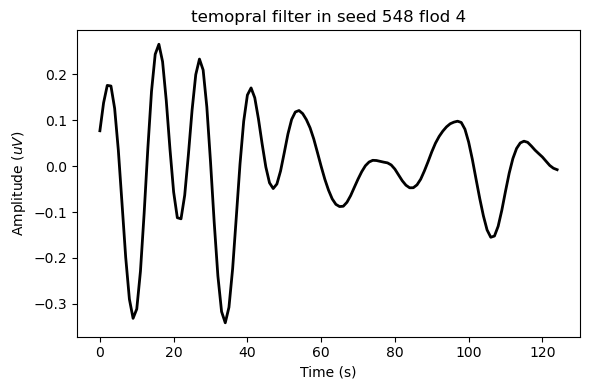

In [ ]:
seed_number=548
fold_number=4
# data_path = "../dataset/model_training/seed_{}/fold_{}/".format(seed_number, fold_number)
data_path = fr'/mnt/dataset0/zhuyan/narcosis/run_in_much_time_0612_lr_0.0015_wd_0.007/seed_{seed_number}/{fold_number}/contribution_test_results/mask_filter/Temporal_contributions_all.npy'
temporal = np.load(data_path, allow_pickle=True)
max_index = np.argmax(temporal['contribution_rate'])
max_filter_index = temporal[max_index]['filter_index']
max_weights = temporal[max_index]['weights']
plt.figure(figsize=(6, 4))
plt.plot(max_weights[0,0,:], lw=2,color='black')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude ($uV$)')
plt.title(f'temopral filter in seed {seed_number} flod {fold_number}')
plt.tight_layout()
plt.show()

In [5]:
REGION_DEFINITION_1 = {
    'Forehead': list(range(0, 2)),          # 前额叶
    'Frontal': list(range(2, 12)),          # 额叶
    'Center': [12, 13, 14, 17, 18],         # 中央区
    'Temporal': [15, 16, 19, 20, 24, 25],   # 颞叶 
    'Parietal': list(range(21, 24)),        # 顶叶
    'Occipital': list(range(26, 29))        # 枕叶
}

REGION_DEFINITION_2 = {
    'Forehead': list(range(0, 2)), 
    'Frontal': list(range(2, 12)), 
    'Center': [7, 8, 9, 12, 13, 14, 17, 18, 21, 22, 23], 
    'Temporal': [5, 6, 10, 11, 15, 16, 19, 20, 24, 25],
    'Parietal': list(range(21, 24)) + list(range(26, 29))
}

In [6]:
def extract_eeg_features_per_channel(filtered_data_combined, filter, net_dict):
    eeg_features_avg = {}
    eeg_labels = []
    subject_ids = []
    ratios = {}
    highlight_regions_per_channel = {}  # 用于保存高亮区域的坐标

    progress_bar = tqdm(total=len(filtered_data_combined), desc='Processing EEG data')
    segment_number = 0
    for element in filtered_data_combined:
        data = element[0]
        data_label = element[1]
        subject_id = element[2]
        segment_number += 1

        data = standardize_segment(data)
        all_data_torch = torch.tensor(data, dtype=torch.float32).to('cuda')
        filter_torch = torch.tensor(filter, dtype=torch.float32).to('cuda').view(1, 1, -1)

        for region in net_dict.keys():
            if region not in eeg_features_avg:
                eeg_features_avg[region] = []
                ratios[region] = []

        for channel in range(data.shape[0]):
            data_channel = all_data_torch[channel, :].unsqueeze(0).unsqueeze(0)
            convolved_data = F.conv1d(data_channel, filter_torch)
            convolved_data_abs = torch.abs(convolved_data)

            avg = torch.mean(convolved_data_abs).item()
            std = torch.std(convolved_data_abs).item()
            threshold = 3 * std + avg

            for region, indices in net_dict.items():
                if channel in indices:
                    eeg_features_avg[region].append(avg)

                    # 检测超过阈值
                    convolved_data_np = convolved_data_abs.cpu().detach().numpy().squeeze()
                    exceeds_threshold = np.where((convolved_data_np > threshold))[-1]

                    highlight = np.zeros_like(convolved_data_np, dtype=bool)
                    interval = 62

                    for i in exceeds_threshold:
                        start = max(0, i - interval)
                        end = min(len(convolved_data_np) - 1, i + interval)
                        segment = convolved_data_np[start:end + 1]
                        if np.sum(segment > threshold) >= 3:
                            highlight[start:end + 1] = True

                    # 合并连续的高亮区间
                    highlight_intervals = []
                    i = 0
                    while i < len(highlight):
                        if highlight[i]:
                            start = i
                            while i < len(highlight) and highlight[i]:
                                i += 1
                            end = i
                            highlight_intervals.append((start, end))
                        i += 1

                    # 合并重叠的高亮区间
                    merged_intervals = []
                    for start, end in highlight_intervals:
                        if not merged_intervals or start > merged_intervals[-1][1]:
                            merged_intervals.append([start, end])
                        else:
                            merged_intervals[-1][1] = max(merged_intervals[-1][1], end)

                    # 保存高亮区域的坐标
                    if segment_number not in highlight_regions_per_channel:
                        highlight_regions_per_channel[segment_number] = {}
                    if region not in highlight_regions_per_channel[segment_number]:
                        highlight_regions_per_channel[segment_number][region] = {}
                    if channel not in highlight_regions_per_channel[segment_number][region]:
                        highlight_regions_per_channel[segment_number][region][channel] = []

                    highlight_regions_per_channel[segment_number][region][channel] = merged_intervals  # 存储合并后的区间

                    # 计算 ratio
                    total_length = len(convolved_data_np)
                    merged_length = sum(end - start + 1 for start, end in merged_intervals)
                    ratio = merged_length / total_length
                    ratios[region].append(ratio)

        eeg_labels.append(data_label)
        subject_ids.append(subject_id)
        progress_bar.update(1)

    progress_bar.close()
    return eeg_features_avg, eeg_labels, subject_ids, highlight_regions_per_channel, ratios

def standardize_segment(data):
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data.T).T
    return standardized_data

In [ ]:
net_id = 1
avg_A, labels_A, subject_ids_A, ratios_A, target_wave_A = extract_eeg_features_per_channel(filtered_data_combined_A, max_weights, REGION_DEFINITION_1)
avg_B, labels_B, subject_ids_B, ratios_B, target_wave_B = extract_eeg_features_per_channel(filtered_data_combined_B, max_weights, REGION_DEFINITION_1)

results = {
        'max_filter_index': max_filter_index,
        'max_weights': max_weights,
        'ratios_POD': ratios_A,
        'ratios_non-POD': ratios_B,
        'avg_POD':avg_A,
        'avg_non-POD':avg_B,
        'subject_POD':subject_ids_A,
        'subject_non-POD':subject_ids_B,
        'target_wave_POD':target_wave_A,
        'target_wave_non-POD':target_wave_B
    }

save_dir = "../dataset/spindle_detection"
os.makedirs(save_dir, exist_ok=True) 

file_path = os.path.join(
    save_dir, f"seed_{seed_number}_fold_{fold_number}_net_{net_id}.pkl"
)

with open(file_path, 'wb') as f:
    pickle.dump(results, f)

Processing EEG data: 100%|██████████| 4237/4237 [02:14<00:00, 31.45it/s]
